In [133]:
import numpy as np
import math
from matplotlib import pyplot as plt
import cv2

In [134]:
def gause_filter(img, height, width, si):
    res = np.zeros(shape=(height, width))
    Gause = np.array([[0.5, 0.75, 0.5], [0.75, 1.0, 0.75], [0.5, 0.75, 0.5]])
    for i in range(height - 2):
        for j in range(width - 2):
            res[i + 1][j + 1] = round(np.sum(np.multiply(Gause, img[i:i + 3, j:j + 3]) / si))
    return res


def sobel_filter(img, height, width):
    res = np.zeros(shape=(height, width))
    angels = np.zeros(shape=(height, width))
    Gx = np.array([[1.0, 0.0, -1.0], [2.0, 0.0, -2.0], [1.0, 0.0, -1.0]])
    Gy = np.array([[1.0, 2.0, 1.0], [0.0, 0.0, 0.0], [-1.0, -2.0, -1.0]])
    for i in range(height - 2):
        for j in range(width - 2):
            gx = np.sum(np.multiply(Gx, img[i:i + 3, j:j + 3]))
            gy = np.sum(np.multiply(Gy, img[i:i + 3, j:j + 3]))
            g = np.sqrt(gx ** 2 + gy ** 2)
            res[i + 1][j + 1] = g
            if g != 0:
                angels[i + 1][j + 1] = round(math.atan2(gy, gx) /
                                              (math.pi / 4)) * (math.pi / 4)
            else:
                angels[i + 1][j + 1] = float("NaN")
    return res, angels


def check(img, x, y, v):
    (height, width) = np.shape(img)
    if 0 <= x <= height - 1 and 0 <= y <= width - 1 and img[x][y] <= v:
        return True
    else:
        return False


def sign(val):
    if -0.000001 < val < -0.000001:
        return 0
    elif val < 0:
        return -1
    else:
        return 1


def NMS(img, angels, height, width):
    res = np.zeros(shape=(height, width))
    for i in range(height):
        for j in range(width):
            if math.isnan(angels[i][j]):
                continue
            dx = sign(math.cos(angels[i][j]))
            dy = sign(math.sin(angels[i][j]))
            if check(img, i + dx, j + dy, img[i][j]):
                res[i + dx][j + dy] = 0
            if check(img, i - dx, j - dy, img[i][j]):
                res[i - dx][j - dy] = 0
            res[i][j] = img[i][j]
    return res


def two_filtration(img, mi, ma):
    (height, width) = np.shape(img)
    step = np.zeros(shape=(height, width))
    res = np.zeros(shape=(height, width))
    for i in range(height):
        for j in range(width):
            p = img[i][j]
            if p <= mi:
                step[i][j] = 0
            elif p >= ma:
                step[i][j] = 255
            else:
                step[i][j] = p
    paths = [[-1, -1, -1, 0, 0, 1, 1, 1],
             [-1, 0, 1, -1, 1, -1, 0, 1]]
    for i in range(height):
        for j in range(width):
            p = step[i][j]
            if p == 255:
                res[i][j] = 255
                for k in range(8):
                    dx = paths[0][k]
                    dy = paths[1][k]
                    x = i
                    y = j
                    while True:
                        x += dx
                        y += dy
                        if x < 0 or x > height - 1 or y < 0 or \
                            x > width - 1 or step[x][y] == 0 or step[x][y] == 255:
                            break
                        res[x][y] = 255
            else:
                res[i][j] = 0
    return res


def find_ones(img):
    height, width = np.shape(img)
    res = []
    for j in range(width):
        for i in range(height):
            if img[i][j] > 0:
                res.append([j, i])
    return res


def delta(x1, y1, x2, y2):
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** .5


def hough(img, min_b, max_b, max_a, min_votes, diff):
    res = []
    height, width = np.shape(img)
    pixels = find_ones(img)
    acc = np.zeros(max_a)
    for p1 in range(len(pixels) - 1):
        for p2 in range(len(pixels) - 1, p1 + 2, -1):
            x1, y1 = pixels[p1][0], pixels[p1][1]
            x2, y2 = pixels[p2][0], pixels[p2][1]
            d = delta(x1, y1, x2, y2)
            xc, yc = (x1 + x2) // 2, (y1 + y2) // 2
            a = d / 2
            acc = acc * 0
            if x1 != x2 and max_b > d > min_b:
                alpha = math.atan((y2 - y1) / (x2 - x1))
                for p3 in range(len(pixels)):
                    if (p3 == p1) or (p3 == p2):
                        continue
                    x3, y3 = pixels[p3][0], pixels[p3][1]
                    d3 = delta(x3, y3, xc, yc)
                    if d3 >= a + 10:
                        continue
                    f = delta(x3, y3, x2, y2)
                    if (2 * a * d3) == 0:
                        continue
                    cos_tau = ((a ** 2 + d3 ** 2 - f ** 2) / (2 * a * d3)) ** 2
                    sin_tau = 1 - cos_tau
                    if (a ** 2 - d3 ** 2 * cos_tau) == 0:
                        continue
                    bg = ((a ** 2 * d3 ** 2 * sin_tau) /
                           (a ** 2 - d3 ** 2 * cos_tau)) ** .5
                    if type(bg) is complex:
                        bg = bg.real
                    b = round(bg)
                    if 0 < b < len(acc) and abs(a-b) < diff:
                        acc[b-1] += 1
                m = max(acc)
                if m > min_votes:
                    index, = np.where(acc == m)
                    B = index[0] + 2
                    res.append([round(yc), round(xc), B, round(a),
                                 round(alpha*180/np.pi)])
                    return res
    return res

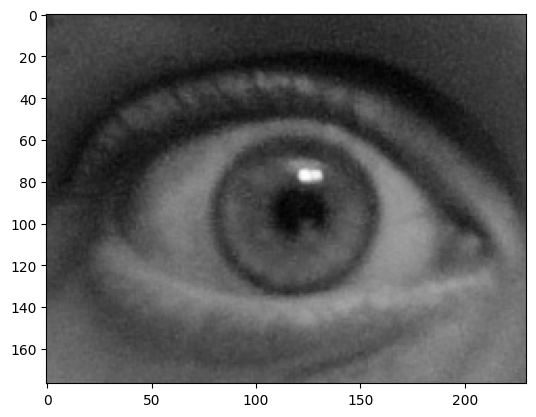

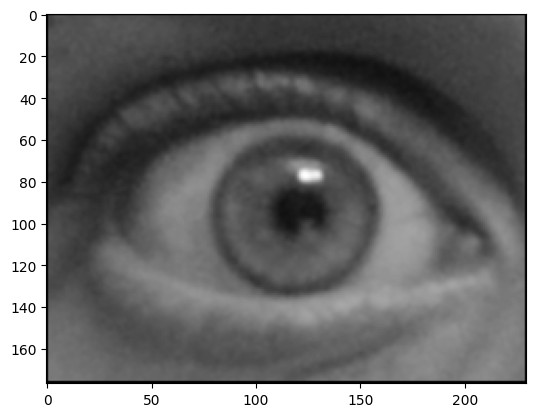

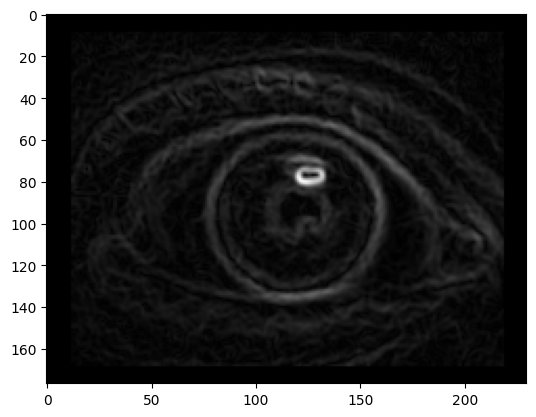

In [135]:



image = cv2.imread("dataset/images/IMG20231216164919_01.jpg")
#image = cv2.imread("photo/b.jpg")
img = np.asarray(image)
height, width, _ = np.shape(img)
r_img, g_img, b_img = img[:, :, 0], img[:, :, 1], img[:, :, 2]
img = 0.299 * r_img + 0.587 * g_img + 0.114 * b_img
plt.imshow(img, cmap="grey")
plt.show()
img0 = gause_filter(img, height, width, 5)
plt.imshow(img0, cmap="grey")
plt.show()
img1, angels = sobel_filter(img0, height, width)
ps = 0.05
for i in range(height):
    for j in range(width):
        if (i/height) >= (1-ps) or (i/height) <= ps or (j/width) >= (1-ps) or (j/width) <= ps:
            img1[i][j] = 0

plt.imshow(img1, cmap="grey")
plt.show()

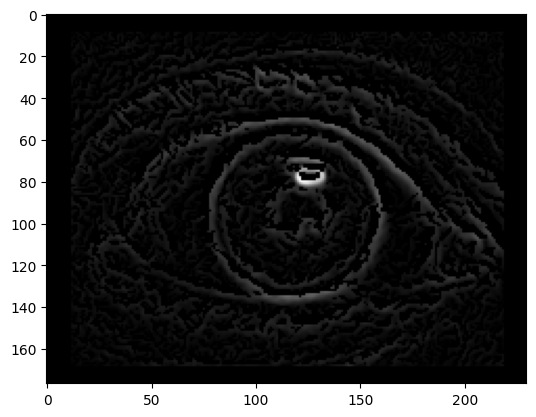

In [136]:
img2 = NMS(img1, angels, height, width)
plt.imshow(img2, cmap="grey")
plt.show()

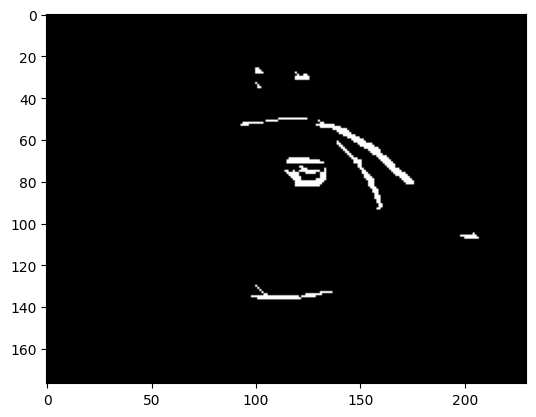

In [137]:
img3 = two_filtration(img2, 80,150)
plt.imshow(img3, cmap="grey")
plt.show()

550


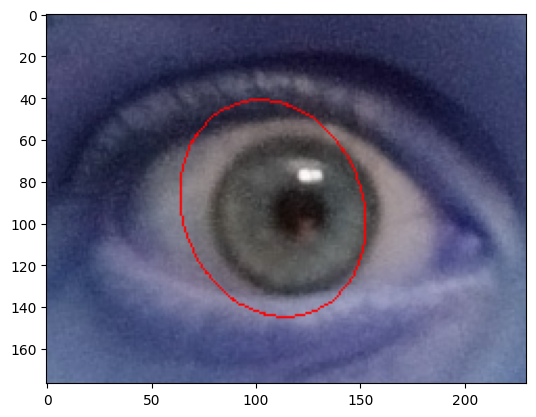

In [138]:
res = hough(img3, 75, 100, 100, 25, 20)
image2 = np.copy(image)
image3 = np.copy(img3)
for i in res:
    cv2.ellipse(image2, (i[1], i[0]), (i[2], i[3]), i[4], 0, 360, (255, 0, 0))
plt.imshow(image2, cmap="grey")

In [139]:
import numpy as np
def Gauss(x, y, sigma):
    return (1/(2*np.pi*sigma**2))*np.e**(-(x**2+y**2)/(2*sigma**2))
def gen_G(size, sigma):
    m = [[[] for j in range(size)] for i in range(size)]
    shift = round(sigma/2)
    for y in range(size):
        for x in range(size):
            m[y][x] = Gauss(x - shift, y - shift, sigma=sigma)
    return m
print(gen_G(3, 1))

[[0.15915494309189535, 0.09653235263005391, 0.021539279301848634], [0.09653235263005391, 0.05854983152431917, 0.013064233284684921], [0.021539279301848634, 0.013064233284684921, 0.0029150244650281948]]
